In [1]:
from decimal import Decimal
import numpy as np
import pandas as pd
from datetime import timedelta
import requests
import json
import datetime
from scipy import stats
from scipy.stats import gamma
from scipy.stats import powerlaw
import scipy.stats as stats
from scipy.odr import *
import matplotlib.pyplot as plt
import math
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
delta = np.random.exponential(1, 1000)

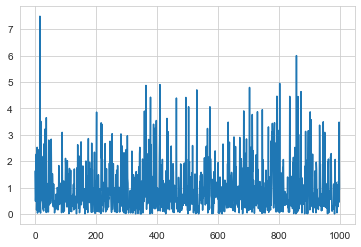

In [3]:
plt.plot(delta)

plt.show()

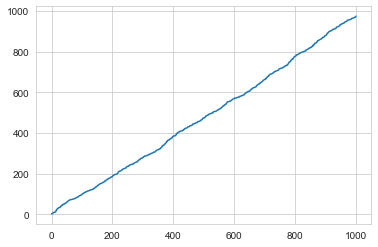

In [4]:
plt.plot(delta.cumsum())

In [5]:
def two_ax_plot(first_array, second_array):
    fig, ax1 = plt.subplots(figsize=(12,6))
    color = 'tab:blue'
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlabel('Transaction Count')
    ax1.set_ylabel('Delta SNT',color=color)
    ax1.set_title('Treasury Accumulation')
    ax1.plot(first_array, label = 'Daily Delta to Treasury', color = color)
    ax1.legend(bbox_to_anchor=(0.05, .75), loc=3, borderaxespad=0.)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:green'
    ax2.set_ylabel('Total SNT', color=color)  # we already handled the x-label with ax1
    ax2.plot(second_array, label = 'Total SNT to Treasury', color = color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(bbox_to_anchor=(0.80, 0.75), loc=2, borderaxespad=0.)
    #plt.ylim(-0.5,0.5)
    fig.tight_layout()
    return fig.savefig('flow.png', bbox_inches='tight')

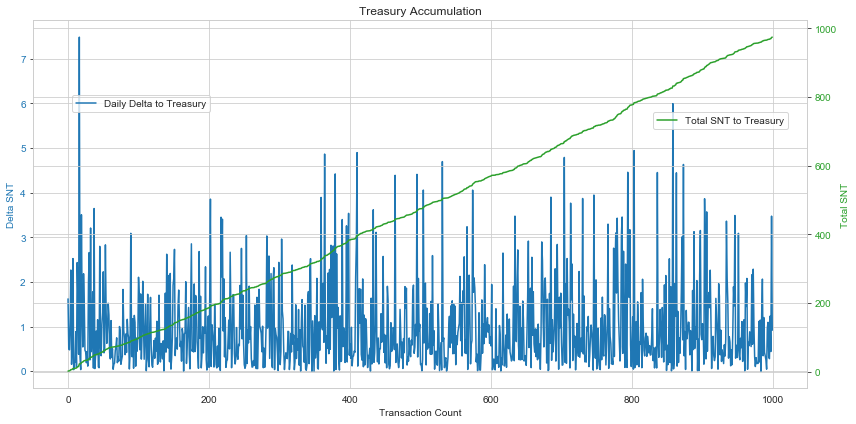

In [6]:
two_ax_plot(delta, delta.cumsum())

In [7]:
alpha_array = np.arange(0.1,1.1,0.2)
alpha_array = np.round(alpha_array,1)

In [8]:
balances = pd.DataFrame()
balance = delta.cumsum()
for alpha in alpha_array:
    reward = alpha * balance
    balance = balance - reward
    balances[str(alpha)] = balance    

In [9]:
balances.head()

,0.1,0.3,0.5,0.7,0.9
0,1.458038,1.020627,0.510313,0.153094,0.015309
1,1.912326,1.338628,0.669314,0.200794,0.020079
2,2.342703,1.639892,0.819946,0.245984,0.024598
3,3.312072,2.318451,1.159225,0.347768,0.034777
4,5.352440,3.746708,1.873354,0.562006,0.056201


In [10]:
def two_ax_plot_2(first_array, second_array):
    fig, ax1 = plt.subplots(figsize=(12,6))
    color = 'tab:blue'
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlabel('Transaction Count')
    ax1.set_ylabel('Delta SNT',color=color)
    ax1.set_title('Treasury Accumulation with Linear Dynamic Reward Allocation')
    ax1.plot(first_array, label = 'Daily Delta to Treasury', color = color)
    ax1.legend(bbox_to_anchor=(0.05, .75), loc=3, borderaxespad=0.)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:gray'
    ax2.set_ylabel('Total SNT', color=color)  # we already handled the x-label with ax1
    for alpha in alpha_array:
        ax2.plot(second_array[str(alpha)], label = "Reward factor = " + str(alpha),color = str(alpha-0.1))
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(bbox_to_anchor=(0.43, 0.96), loc=2, borderaxespad=0.)
    #plt.ylim(-0.5,0.5)
    fig.tight_layout()
    return fig.savefig('reward.png', bbox_inches='tight')

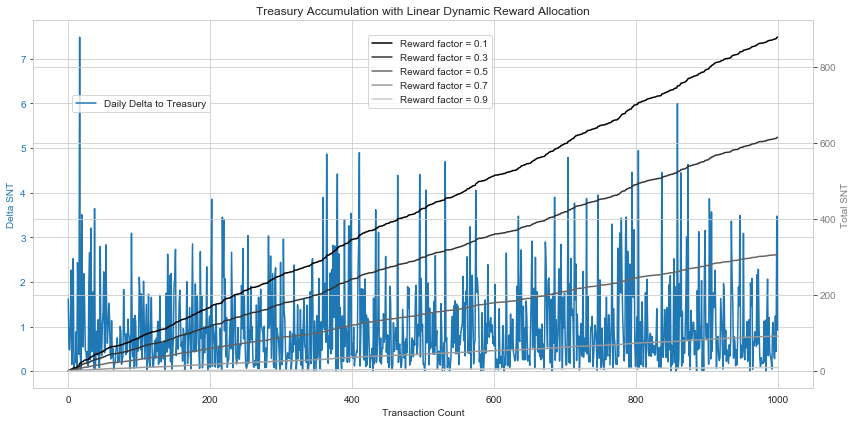

In [11]:
two_ax_plot_2(delta,balances)

### Power Law Distribution of Expected Waiting Times

A general form can be:
$$p(x) = Cx^{−α} \quad for \quad x ≥ x_{min}$$

In [12]:
a = 0.7
mean, var, skew, kurt = powerlaw.stats(a, moments='mvsk')

In [13]:
x = np.linspace(powerlaw.ppf(0.01, a), powerlaw.ppf(0.99, a), 100)

In [14]:
rv = powerlaw(a)

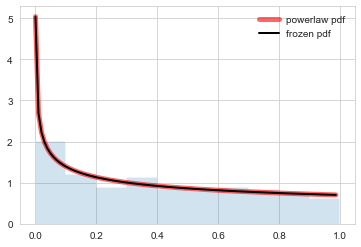

In [15]:
fig, ax = plt.subplots(1, 1)
r = powerlaw.rvs(a, size=1000)
ax.plot(x, powerlaw.pdf(x, a),'r-', lw=5, alpha=0.6, label='powerlaw pdf')
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

Normalization constant is derived as: $C = (α − 1)x^{α−1}_{min}$ 

Normalized power law:

\begin{equation}
    p(x) = \frac{\alpha -1}{x_{min}} \Big(\frac{x}{x_{min}}\Big)^{-\alpha} \quad \mbox{for} \quad x\geq x_{min}, \alpha > 1
\end{equation}

In [16]:
def power_law(x, alpha, x_min):
    first_term = np.divide(alpha - 1,x_min)
    second_term = np.divide(x,x_min)
    second_term = np.power(second_term,-alpha)
    p = first_term * second_term
    return p

In [17]:
alpha = 1.2
x_min = 1

In [18]:
power_law(1,alpha,x_min)

0.19999999999999996

In [19]:
x = np.arange(2,1000)

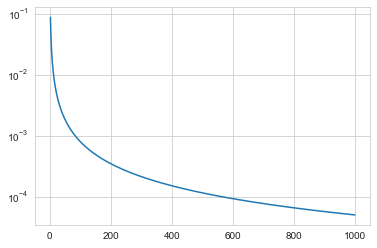

In [20]:
plt.plot(x,power_law(x,alpha,x_min))
plt.yscale('log')

In [21]:
# Data from Dataworld Health Center Call Metrics
df = pd.read_csv('https://query.data.world/s/fzdjsqluqxbp6a572hr6k6uevb2crz')

In [22]:
df.head()

,Month,Inbound Calls,Average Speed of Answer in Secs,Abandoned Calls,Call Abandonment Rate,In-person visits
0,01/01/2018 12:00:00 AM,5035,16,49,0.96%,1259
1,12/01/2017 12:00:00 AM,5478,29,76,1.37%,1221
2,11/01/2017 12:00:00 AM,3821,31,64,1.65%,996
3,10/01/2017 12:00:00 AM,11333,73,594,4.98%,1763
4,09/01/2017 12:00:00 AM,3495,13,31,0.88%,1075


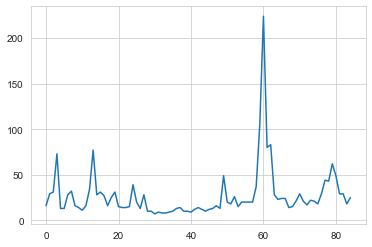

In [23]:
df['Average Speed of Answer in Secs'].plot()

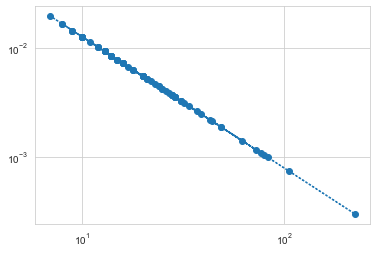

In [24]:
plt.plot(df['Average Speed of Answer in Secs'],power_law(df['Average Speed of Answer in Secs'],alpha,x_min), ls = ':', marker = 'o')
plt.yscale('log')
plt.xscale('log')

In [25]:
# fig, ax = plt.subplots(1, 1)
# r = powerlaw.rvs(a, size=1000)
# ax.plot(df['Average Speed of Answer in Secs'], powerlaw.pdf(df['Average Speed of Answer in Secs'], a),'r-', lw=5, alpha=0.6, label='powerlaw pdf')
# ax.plot(df['Average Speed of Answer in Secs'], rv.pdf(df['Average Speed of Answer in Secs']), 'k-', lw=2, label='frozen pdf')
# ax.hist(df['Average Speed of Answer in Secs'], density=True, histtype='stepfilled', alpha=0.2)
# ax.legend(loc='best', frameon=False)
# plt.show()

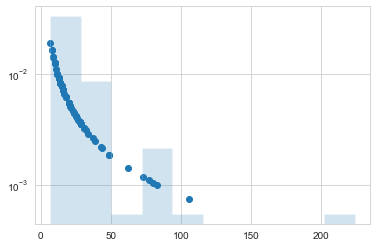

In [26]:
fig, ax = plt.subplots(1, 1)
#r = powerlaw.rvs(a, size=1000)
#ax.plot(df['Average Speed of Answer in Secs'], powerlaw.pdf(df['Average Speed of Answer in Secs'], a),'r-', lw=5, alpha=0.6, label='powerlaw pdf')
ax.scatter(df['Average Speed of Answer in Secs'],power_law(df['Average Speed of Answer in Secs'],alpha,x_min))
ax.hist(df['Average Speed of Answer in Secs'], density=True, histtype='stepfilled', alpha=0.2)
#ax.legend(loc='best', frameon=False)
plt.yscale('log')
plt.show()

In [27]:
# rows = 6
# cols = 1
# fig, axes = plt.subplots(nrows=rows, ncols=cols)
# alphas = np.arange(1,7) + 0.5
# for count, alpha in enumerate(alphas):
    
#     ax = axes[count]
#     print(ax)
#     ax.scatter(df['Average Speed of Answer in Secs'],power_law(df['Average Speed of Answer in Secs'],alpha,x_min))
#     ax.hist(df['Average Speed of Answer in Secs'], density=True, histtype='stepfilled', alpha=0.2)
#     #ax.legend(loc='best', frameon=False)
#     ax.set_xlabel('Waiting Time in Seconds')
#     ax.set_ylabel('Probability')
#     ax.set_title('Alpha = ' + str(alpha))
    
# plt.yscale('log')

# plt.show()

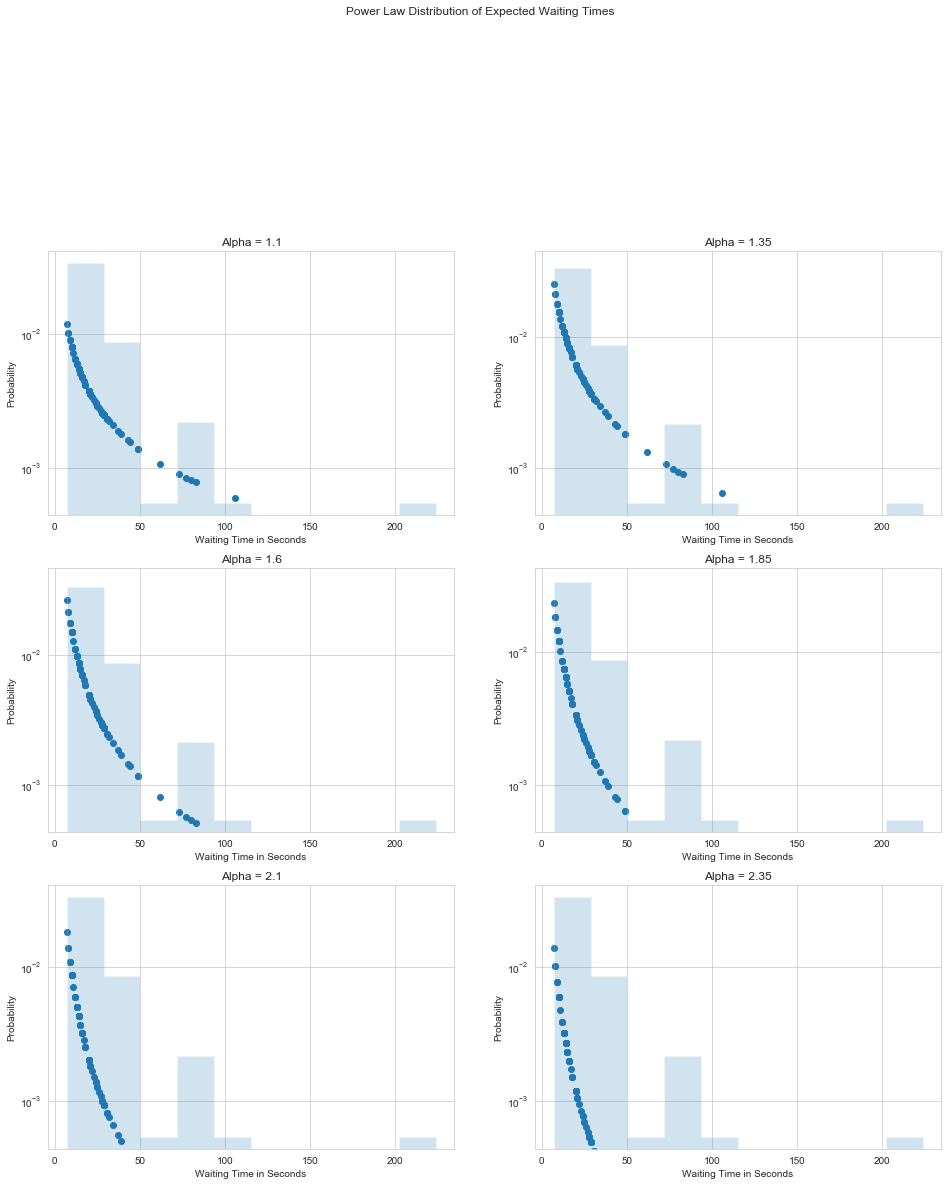

In [28]:
rows = 6
cols = 1
# fig, axes = plt.subplots(nrows=rows, ncols=cols)

alphas = np.arange(1,2.5,0.25) + 0.1
plt.figure(figsize=(16,34))

for count, alpha in enumerate(alphas):
    plt.subplot(len(alphas),2,count+1)
    plt.scatter(df['Average Speed of Answer in Secs'],power_law(df['Average Speed of Answer in Secs'],alpha,x_min))
    plt.hist(df['Average Speed of Answer in Secs'], density=True, histtype='stepfilled', alpha=0.2)
    #ax.legend(loc='best', frameon=False)
    plt.xlabel('Waiting Time in Seconds')
    plt.ylabel('Probability')
    plt.title('Alpha = ' + str(alpha))
#     plt.ylim(0)
    plt.yscale('log')
plt.suptitle('Power Law Distribution of Expected Waiting Times')
plt.show()

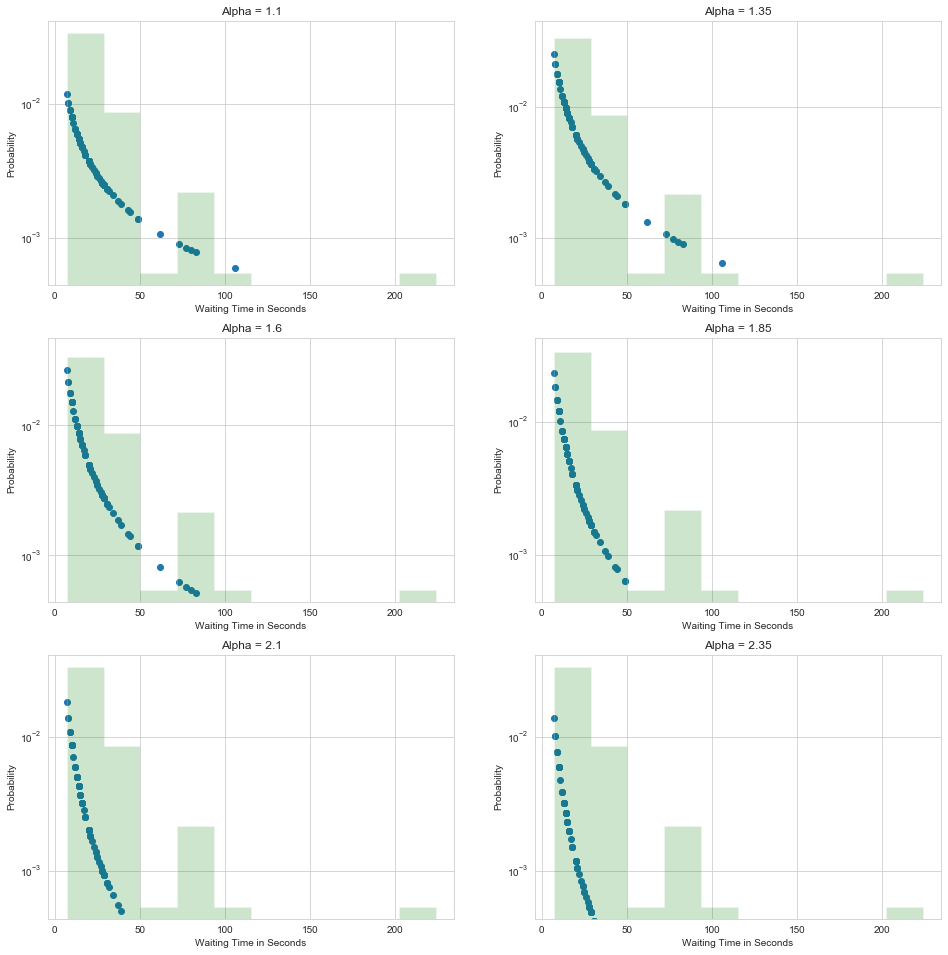

In [29]:
rows = 6
cols = 1
# fig, axes = plt.subplots(nrows=rows, ncols=cols)

alphas = np.arange(1,2.5,0.25) + 0.1
plt.figure(figsize=(16,34))

for count, alpha in enumerate(alphas):
    plt.subplot(len(alphas),2,count+1)
    plt.scatter(df['Average Speed of Answer in Secs'],power_law(df['Average Speed of Answer in Secs'],alpha,x_min))
    plt.hist(df['Average Speed of Answer in Secs'], density=True, histtype='stepfilled', alpha=0.2,color='g')
    #ax.legend(loc='best', frameon=False)
    plt.xlabel('Waiting Time in Seconds')
    plt.ylabel('Probability')
    plt.title('Alpha = ' + str(alpha))
#     plt.ylim(0)
    plt.yscale('log')
# plt.suptitle('Power Law Distribution of Expected Waiting Times')
filename = 'alpha_power_law'
plt.savefig(filename,  bbox_inches='tight')

plt.show()

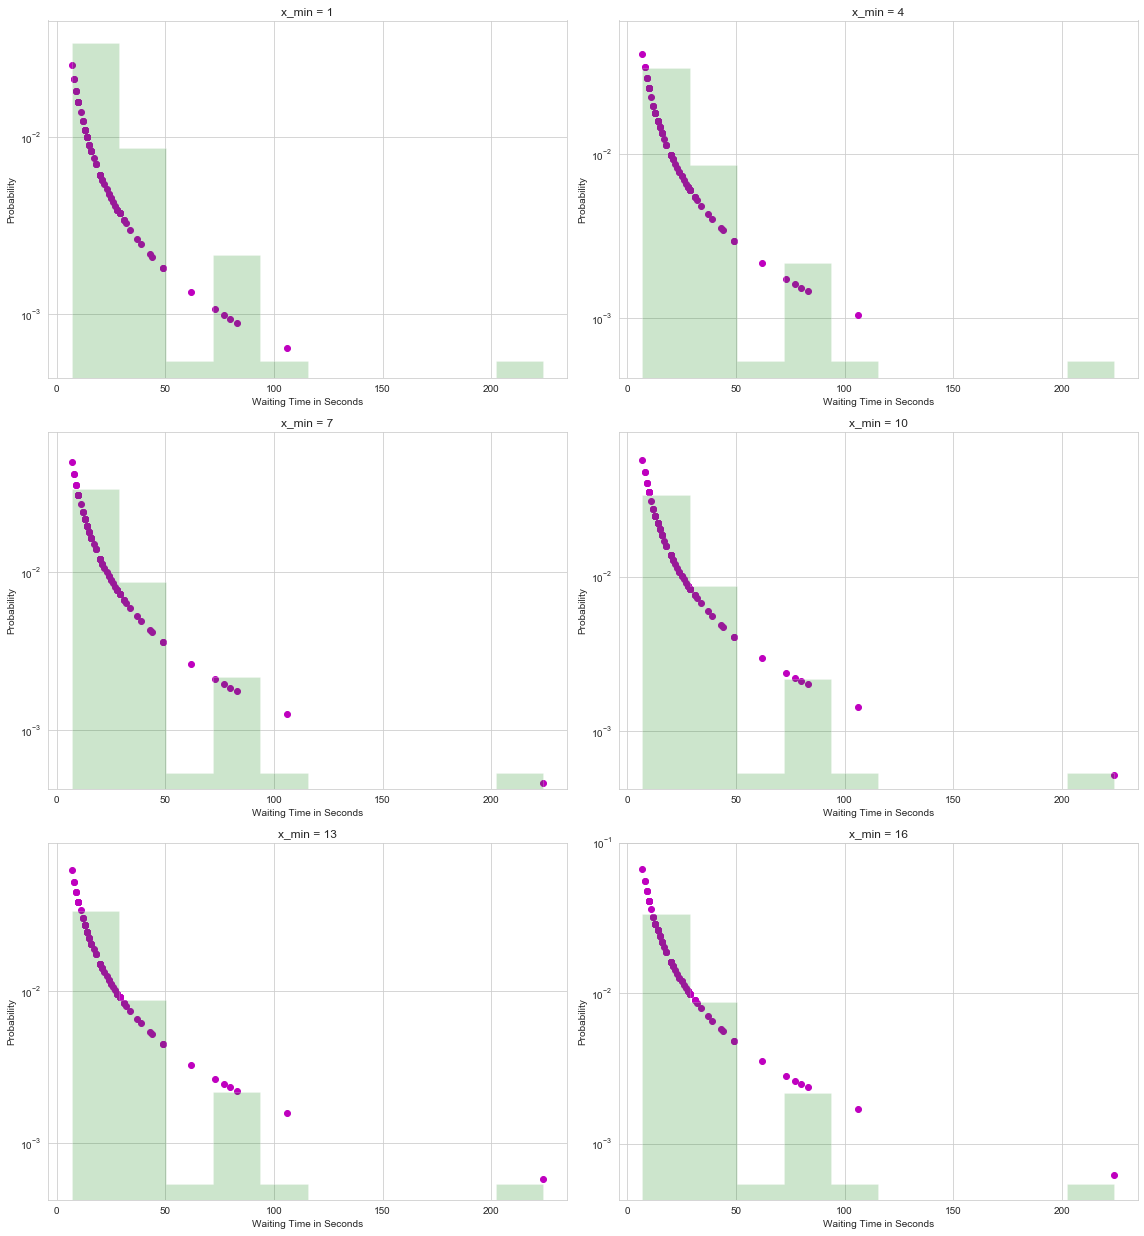

In [30]:
rows = 6
cols = 1
# fig, axes = plt.subplots(nrows=rows, ncols=cols)
alpha = 1.35
x_mins = np.arange(1,18,3)
plt.figure(figsize=(16,34))

for count, x_min in enumerate(x_mins):
    plt.subplot(len(x_mins),2,count+1)
    plt.scatter(df['Average Speed of Answer in Secs'],power_law(df['Average Speed of Answer in Secs'],alpha,x_min), color='m')
    plt.hist(df['Average Speed of Answer in Secs'], density=True, histtype='stepfilled', alpha=0.2, color='g')
    #ax.legend(loc='best', frameon=False)
    plt.xlabel('Waiting Time in Seconds')
    plt.ylabel('Probability')
    plt.title('x_min = ' + str(x_min))
#     plt.ylim(0)
    plt.yscale('log')
plt.tight_layout()
# plt.suptitle('Power Law Distribution of Expected Waiting Times')

filename = 'xmin_power_law'
plt.savefig(filename,  bbox_inches='tight')

plt.show()

The parameter x_min is a vertical scaling parameter. x_min in implementation could be 1, as in 1 block. This would break if x_min were zero, as in the solution is solved in the same block, due to divide by zero. 
*worth investigating*

This can reduce the power law to a one parameter definition.

In [31]:
alphas = np.arange(1,6) + 0.5

In [32]:
alphas

array([1.5, 2.5, 3.5, 4.5, 5.5])

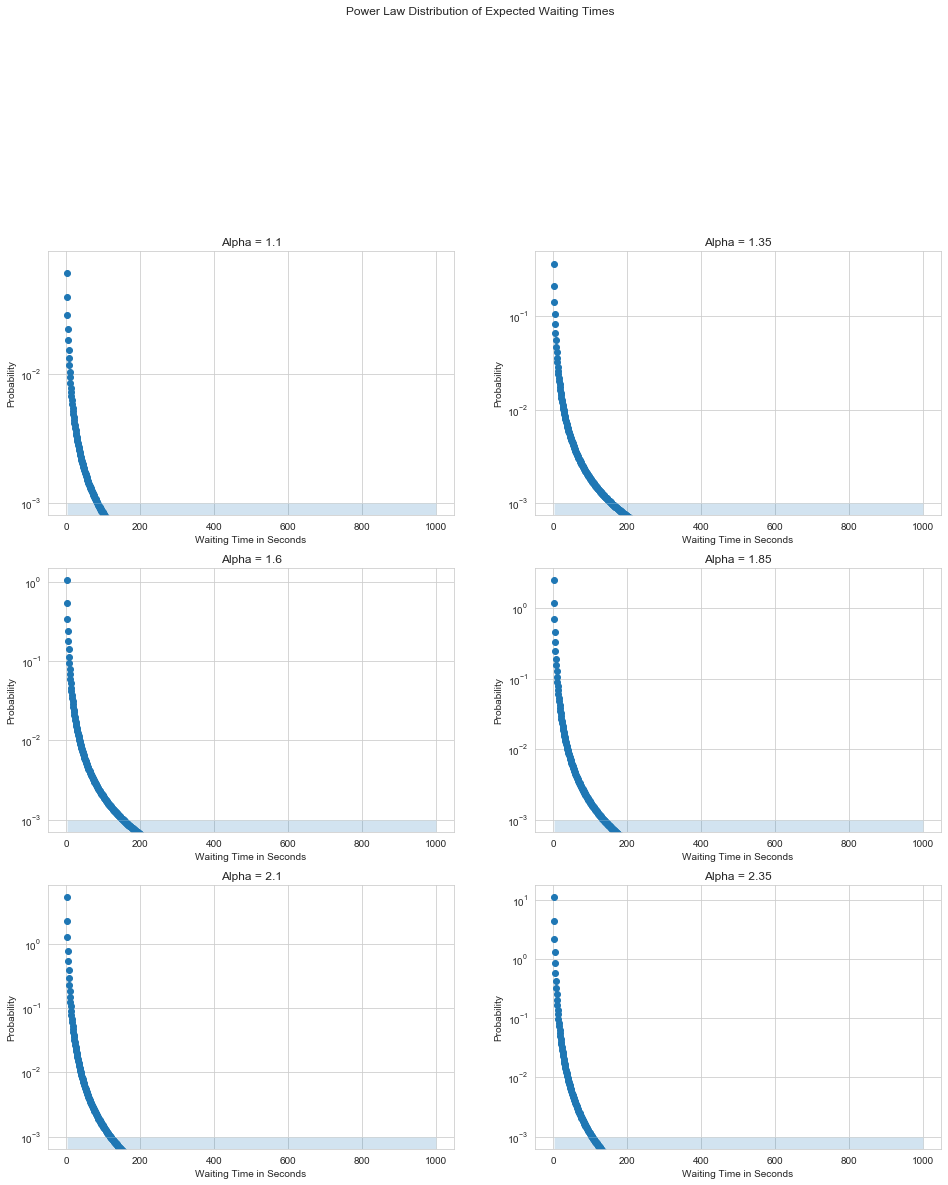

In [33]:
rows = 6
cols = 1
# fig, axes = plt.subplots(nrows=rows, ncols=cols)

alphas = np.arange(1,2.5,0.25) + 0.1
plt.figure(figsize=(16,34))

for count, alpha in enumerate(alphas):
    plt.subplot(len(alphas),2,count+1)
    plt.scatter(x,power_law(x,alpha,x_min))
    plt.hist(x, density=True, histtype='stepfilled', alpha=0.2)
    #ax.legend(loc='best', frameon=False)
    plt.xlabel('Waiting Time in Seconds')
    plt.ylabel('Probability')
    plt.title('Alpha = ' + str(alpha))
#     plt.ylim(0)
    plt.yscale('log')
plt.suptitle('Power Law Distribution of Expected Waiting Times')
plt.show()

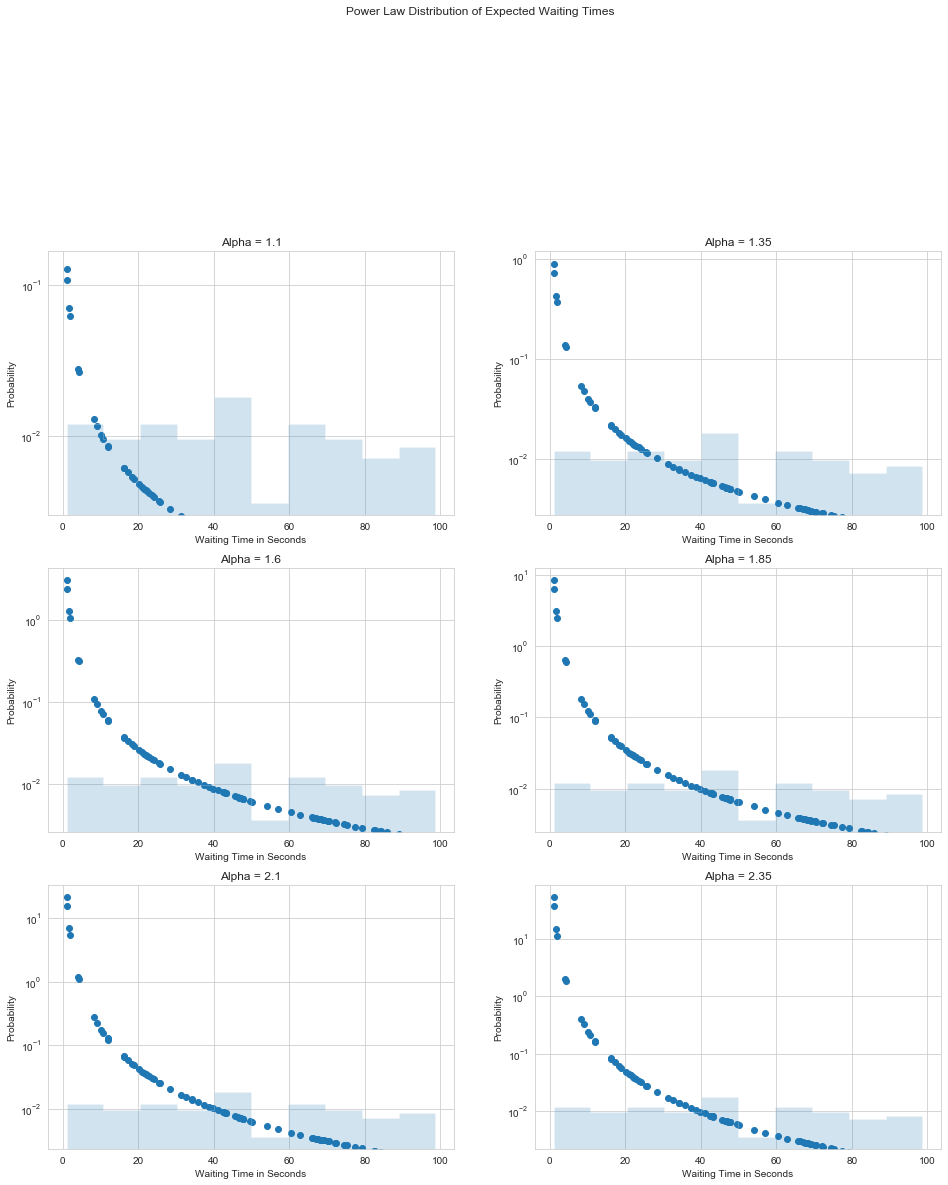

In [34]:
rvs = np.random.rand(len(df['Average Speed of Answer in Secs']))*100
rows = 6
cols = 1
# fig, axes = plt.subplots(nrows=rows, ncols=cols)

alphas = np.arange(1,2.5,0.25) + 0.1
plt.figure(figsize=(16,34))

for count, alpha in enumerate(alphas):
    plt.subplot(len(alphas),2,count+1)
    plt.scatter(rvs,power_law(rvs,alpha,x_min))
    plt.hist(rvs, density=True, histtype='stepfilled', alpha=0.2)
    #ax.legend(loc='best', frameon=False)
    plt.xlabel('Waiting Time in Seconds')
    plt.ylabel('Probability')
    plt.title('Alpha = ' + str(alpha))
#     plt.ylim(0)
    plt.yscale('log')
plt.suptitle('Power Law Distribution of Expected Waiting Times')
plt.show()


Using the likelihood of the dataset in a power law distribution and Bayesian probability, the predicted, maximum likelihood estimate of $\alpha$ is derived as:
\begin{equation}
    \alpha  = 1+n \Big[\sum_{i=1}^n \ln \frac{x_i}{x_{min}}\Big]^{-1}
\end{equation}

The estimated statistical error, $\sigma$, for $n \gg 1$, can be approximated by:
\begin{equation}
    \sigma  = \frac{\alpha -1}{\sqrt{n}}
\end{equation}

In [35]:
def alpha_estimate(data, x_min):
    
    log = np.log(data/x_min)
    log_sum = np.sum(log)
    recip = np.power(log_sum,-1)
    alpha_pred = 1 + recip * len(data)
    
    error_pred = (alpha_pred - 1) / np.sqrt(len(data))
    return alpha_pred, error_pred

In [36]:
alpha_estimate(df['Average Speed of Answer in Secs'],1)

(1.3292396412147525, 0.035711053050383176)

In [37]:
df['Call Abandonment Rate']

0     0.96%
1     1.37%
2     1.65%
3     4.98%
4     0.88%
      ...  
80     1.3%
81     1.8%
82     2.1%
83     1.4%
84     1.4%
Name: Call Abandonment Rate, Length: 85, dtype: object